In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Авторизация
api = KaggleApi()
api.authenticate()

# Загрузка датасета
api.dataset_download_files(
    'dipankarsrirag/topic-modelling-on-emails',  # замените на реальное имя
    path='./emails',
    unzip=True  # автоматическая распаковка
)

Dataset URL: https://www.kaggle.com/datasets/dipankarsrirag/topic-modelling-on-emails


In [2]:
!rmdir /s /q ".\\emails\\Data\\Science\\.ipynb_checkpoints"

In [3]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
import pickle
from nltk.corpus import stopwords, words
import os
import regex
import random
from nltk.tokenize import WordPunctTokenizer, word_tokenize
from string import punctuation
from nltk.stem import WordNetLemmatizer

# Загрузка таблиц токенизатора
nltk.download('punkt_tab')
   

# Функция очистки и токенизации слов
def clean_contents(contents):
    text = str(contents).replace("\\n", " ").replace("\\r", " ").replace("\\", " ").replace(">", " ").replace("<", " ").replace("\t", " ").strip()
    text = re.sub(r'\S+@\S+\.\S+', ' ', text)
    text = text.replace("Reply-To:", " ")
    text = text.replace("NNTP-Posting-Host:", " ")
    text = re.sub(r'\S+@\S+\.\S+', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s\.\,\!\?\-\:]', ' ', text)

    tokenized_word = []
    for word in word_tokenize(text):
        word = regex.sub(u'\p{^Latin}', u'', word.lower())
        tokenized_word.append(word)
    tokenized_word = " ".join(tokenized_word)
    return tokenized_word

# Загрузка файлов в память
email_data = load_files(r"emails/Data")
X, y, y_names = email_data.data, email_data.target, email_data.target_names

# Вывод классов электронных писем
print(y_names)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\RAvakumov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['Crime', 'Entertainment', 'Politics', 'Science']


In [4]:
# Применение функции очистки и токенизации
X_cleaned = [clean_contents(x) for x in X]

# Формирование датафрейма
df = pd.DataFrame(data= np.c_[X_cleaned, y], columns= ['content', 'class'])
print("Тексты email очищены")

Тексты email очищены


<Axes: xlabel='class'>

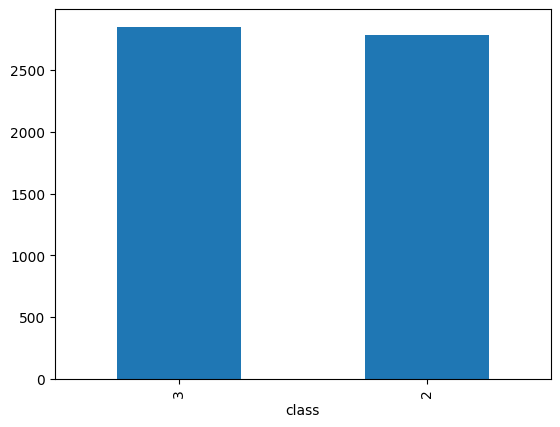

In [5]:
# Удаление дубликатов, вывод соотношения классов
df.drop_duplicates(subset=['content'], inplace=True, keep=False)
df['class'].value_counts().plot.bar()

In [6]:
# Подготовка данных для Doc2Vec
tagged_data = [TaggedDocument(words=_d.split(), tags=[str(i)]) for i, _d in enumerate(df['content'])]
print("Данные для Doc2Vec готовы")

Данные для Doc2Vec готовы


In [7]:
def build_doc2vec(tagged_data, vector_size=200, epochs=50):
    
    model = Doc2Vec(
        vector_size=vector_size,
        min_count=2,           
        window=10,             
        sample=1e-5,
        negative=10,
        hs=0,
        dm=0,                  
        dbow_words=1,          
        epochs=epochs,
        alpha=0.025,
        min_alpha=0.001,
        workers=4
    )

    print("Построение словаря...")
    model.build_vocab(tagged_data)
    
    print(f"Размер словаря: {len(model.wv.key_to_index)}")

    print("Обучение модели...")
    for epoch in range(epochs):
        model.train(
            tagged_data,
            total_examples=model.corpus_count,
            epochs=1
        )
        model.alpha -= 0.0004
        model.min_alpha = model.alpha
        
        if (epoch + 1) % 10 == 0:
            print(f"Эпоха {epoch + 1}/{epochs} завершена")
    
    return model

# Строим модель
doc_2_vec_model = build_doc2vec(tagged_data)

# Сохранение Doc2Vec модели
doc_2_vec_model.save("doc2vec_email_model.model")
print("Модель Doc2Vec построена и сохранена")

Построение словаря...
Размер словаря: 32848
Обучение модели...
Эпоха 10/50 завершена
Эпоха 20/50 завершена
Эпоха 30/50 завершена
Эпоха 40/50 завершена
Эпоха 50/50 завершена
Модель Doc2Vec построена и сохранена


In [8]:
doc_2_vec_model = Doc2Vec.load("doc2vec_email_model.model")
# Получаем векторные представления для всех документов
X_vectors = np.array([doc_2_vec_model.dv[str(i)] for i in range(len(tagged_data))])
y = df['class'].values.astype(int)

# Проверяем размерности
print("Размерность векторов Doc2Vec:", X_vectors.shape)
print("Размерность меток:", y.shape)

Размерность векторов Doc2Vec: (5631, 200)
Размерность меток: (5631,)


In [9]:
# Классификатор CNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vectors)

# Кодирование меток
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))

# Преобразование в one-hot encoding
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

# Разделение на обучающую и проверочную выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

# Форматирование для CNN (добавляем dimension для временных шагов)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Проверяем размерность
print("Размерность train data:", X_train_cnn.shape)
print("Размерность test data:", X_test_cnn.shape)

Размерность train data: (4504, 200, 1)
Размерность test data: (1127, 200, 1)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Функция построения модели CNN
def create_cnn_doc2vec_model(input_shape, num_classes):
    cnn_model = Sequential()

    # Первый сверточный блок
    cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu',
                    input_shape=input_shape, padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.3))

    # Второй сверточный блок
    cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.4))

    # Третий сверточный блок
    cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.5))

    # Выравнивание и полносвязные слои
    cnn_model.add(Flatten())

    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.5))

    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dropout(0.3))

    # Выходной слой
    cnn_model.add(Dense(num_classes, activation='softmax'))

    # Компиляция модели
    cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return cnn_model

# Создание модели
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])
cnn_model = create_cnn_doc2vec_model(input_shape, num_classes)
cnn_model.summary()

C:\Users\RAvakumov\Documents\Учеба\foo\NPL5\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 200, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 100, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 50, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 450,562 (1.72 MB)

 Trainable params: 449,858 (1.72 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callback для раннего прерывания обучения
early_stopping = EarlyStopping(monitor='val_loss', patience=8,
                              restore_best_weights=True, verbose=1)

# Callback для уменьшения скорости обучения
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                             patience=5, min_lr=0.0001, verbose=1)

# Запуск обучения
history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6256 - loss: 0.7839 - val_accuracy: 0.5150 - val_loss: 0.7123 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7266 - loss: 0.5771 - val_accuracy: 0.5649 - val_loss: 0.6635 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7685 - loss: 0.4967 - val_accuracy: 0.7525 - val_loss: 0.4946 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7960 - loss: 0.4456 - val_accuracy: 0.8224 - val_loss: 0.3737 - learning_rate: 0.0010
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8185 - loss: 0.4057 - val_accuracy: 0.8635 - val_loss: 0.3296 - learning_rate: 0.0010
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8357 - loss: 0.3879 - val_accuracy: 0.8824 - val_loss: 0.2896 - learning_rate: 0.0010
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8379 - loss: 0.3625 

In [12]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, Input, Concatenate
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from collections import Counter
import numpy as np

print("Фильтрация словаря...")

# Считаем частоту слов
word_counts = Counter()
for doc in tagged_data:
    word_counts.update(doc.words)

# Оставляем только самые частые слова
top_n_words = 6000
top_words = {word for word, count in word_counts.most_common(top_n_words)}
vocab_size = len(top_words) + 1  

# Создаем словарь word-to-index только для частых слов
word_to_idx = {word: idx for idx, word in enumerate(top_words)}
word_to_idx['<UNK>'] = len(word_to_idx)  # Токен для неизвестных слов
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

print(f"Размер словаря после фильтрации: {vocab_size}")

max_sequence_length = 50  # Максимальная длина последовательности
sequence_length = 20  # глубина последовательности

X_sequences = []
y_next_words = []

for i, doc in enumerate(tagged_data):
    words = doc.words
    if len(words) > sequence_length:  # Пропускаем слишком короткие документы
        # Берем вектор всего документа
        doc_vector = X_vectors[i]
        
        # Создаем последовательности из N слов для предсказания N+1 слова
        for j in range(sequence_length, min(len(words), max_sequence_length + sequence_length)):
            # Берем последовательность из sequence_length предыдущих слов
            sequence = words[j-sequence_length:j]
            next_word = words[j]
            
            # Пропускаем последовательности с редкими словами
            if all(word in top_words for word in sequence) and next_word in top_words:
                # Преобразуем слова в индексы
                sequence_idx = [word_to_idx[word] for word in sequence]
                
                X_sequences.append({
                    'doc_vector': doc_vector,
                    'word_sequence': sequence_idx  
                })
                y_next_words.append(word_to_idx[next_word])

print(f"Создано {len(X_sequences)} последовательностей после фильтрации")

# подготовка данных
X_doc_vectors = np.array([seq['doc_vector'] for seq in X_sequences])
X_word_sequences = np.array([seq['word_sequence'] for seq in X_sequences]) 
y_next_words = np.array(y_next_words)
y_categorical = to_categorical(y_next_words, num_classes=vocab_size)

# Разделение на тренировочную и тестовую выборку
X_doc_train, X_doc_test, X_word_train, X_word_test, y_train, y_test = train_test_split(
    X_doc_vectors, X_word_sequences, y_categorical, test_size=0.2, random_state=42  
)

print(f"Размеры данных для обучения:")
print(f"X_doc_train: {X_doc_train.shape}")       
print(f"X_word_train: {X_word_train.shape}")      
print(f"y_train: {y_train.shape}")              

Фильтрация словаря...
Размер словаря после фильтрации: 6001
Создано 49861 последовательностей после фильтрации
Размеры данных для обучения:
X_doc_train: (39888, 200)
X_word_train: (39888, 20)
y_train: (39888, 6001)


In [13]:
from keras.layers import LSTM, Dense, Embedding, Dropout, Input, Concatenate, RepeatVector

print("Создание модели LSTM для последовательностей...")

sequence_length = X_word_train.shape[1]  # Автоматически получаем длину последовательности 

# Вход для вектора документа
doc_input = Input(shape=(200,), name='doc_input')
doc_dense = Dense(100, activation='relu')(doc_input)
doc_dropout = Dropout(0.3)(doc_dense)

word_input = Input(shape=(sequence_length,), name='word_input') 
word_embedding = Embedding(input_dim=vocab_size, output_dim=100)(word_input) 

# Размножаем вектор документа для каждого элемента последовательности
doc_repeated = RepeatVector(sequence_length)(doc_dropout) 

# Объединяем эмбеддинги слов и вектор документа
merged = Concatenate(axis=-1)([word_embedding, doc_repeated])

# LSTM слои
lstm_layer1 = LSTM(512, return_sequences=True, dropout=0.3)(merged)
lstm_layer2 = LSTM(256, dropout=0.3)(lstm_layer1) 

# Выходной слой
output = Dense(vocab_size, activation='softmax')(lstm_layer2)

# LSTM-модель
model = Model(inputs=[doc_input, word_input], outputs=output)

# Компиляция модели
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Создание модели LSTM для последовательностей...


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ doc_input (InputLayer)        │ (None, 200)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 100)               │          20,100 │ doc_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ word_input (InputLayer)       │ (None, 20)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 100)               │               0 │ dense_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 20, 100)           │         600,100 │ word_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ repeat_vector (RepeatVector)  │ (None, 20, 100)           │               0 │ dropout_5[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 20, 200)           │               0 │ embedding[0][0],           │
│                               │                           │                 │ repeat_vector[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 20, 512)           │       1,460,224 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 256)               │         787,456 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 6001)              │       1,542,257 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,410,137 (16.82 MB)

 Trainable params: 4,410,137 (16.82 MB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print(f"X_doc_train shape: {X_doc_train.shape}")
print(f"X_word_train shape: {X_word_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Callback для раннего прерывания обучения
early_stopping = EarlyStopping(monitor='val_loss', patience=8,
                              restore_best_weights=True, verbose=1)

# Callback для уменьшения скорости обучения
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                             patience=5, min_lr=0.0001, verbose=1)

history = model.fit(
    [X_doc_train, X_word_train],
    y_train,
    batch_size=128,
    epochs=50,  
    validation_data=([X_doc_test, X_word_test], y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

X_doc_train shape: (39888, 200)
X_word_train shape: (39888, 20)
y_train shape: (39888, 6001)
Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 62s 190ms/step - accuracy: 0.0562 - loss: 6.7688 - val_accuracy: 0.0536 - val_loss: 6.6016 - learning_rate: 0.0010
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 64s 206ms/step - accuracy: 0.0561 - loss: 6.4829 - val_accuracy: 0.0536 - val_loss: 6.6107 - learning_rate: 0.0010
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 57s 182ms/step - accuracy: 0.0573 - loss: 6.4159 - val_accuracy: 0.0634 - val_loss: 6.4713 - learning_rate: 0.0010
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 56s 180ms/step - accuracy: 0.0762 - loss: 6.1635 - val_accuracy: 0.0756 - val_loss: 6.2638 - learning_rate: 0.0010
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - accuracy: 0.0900 - loss: 5.8967 - val_accuracy: 0.0842 - val_loss: 6.1114 - learning_rate: 0.0010
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 61s 194ms/step - accuracy: 0.1011 - loss: 5.6656 - val_accuracy: 0.0961 - val_loss: 6.0059 -

In [15]:
model.save('lstm_model.h5')
print("LSTM-модель сохранена как lstm_model.h5")

LSTM-модель сохранена как lstm_model.h5


In [16]:
# Предсказание класса вектора
def classify(doc_vector, cnn_model):

    doc_vector_scaled = scaler.transform([doc_vector])
    doc_vector_cnn = doc_vector_scaled.reshape(1, doc_vector_scaled.shape[1], 1)
   
    predictions = cnn_model.predict(doc_vector_cnn, verbose=0)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    return predicted_class

In [20]:
# Генерация текста с использованием CNN-классификатора
def generate_text_with_cnn(model, cnn_model, start_sequence, num_words=20, 
                          temperature=1.0, top_k=10, class_id=2):

    # Выбираем вектор документа нужного класса
    class_indices = np.where(y == class_id)[0]
    if len(class_indices) == 0:
        class_indices = [0]
    
    doc_vector = X_vectors[random.choice(class_indices)]
    
    # Предсказываем класс документа с помощью CNN
    predicted_class = classify(doc_vector, cnn_model)
    print(f"CNN предсказал класс: {predicted_class}, ожидаемый: {class_id}")
    
    # Если CNN не согласен с выбранным классом, ищем другой документ
    if predicted_class != class_id:
        print("Ищем документ, который CNN классифицирует правильно...")
        found = False
        for attempt in range(100):  # Пробуем 10 раз
            doc_vector = X_vectors[random.choice(class_indices)]
            predicted_class = classify(doc_vector, cnn_model)
            if predicted_class == class_id:
                found = True
                print(f"Найден подходящий документ на попытке {attempt + 1}")
                break
        
        if not found:
            print("Не удалось найти документ нужного класса, используем любой")
    
    # Генерация текста
    current_sequence = [word_to_idx.get(word, word_to_idx['<UNK>']) 
                       for word in start_sequence]
    generated_text = start_sequence.copy()
    
    # Убедимся, что начальная последовательность правильной длины
    if len(current_sequence) > sequence_length:
        current_sequence = current_sequence[-sequence_length:]
    elif len(current_sequence) < sequence_length:
        # Дополняем до нужной длины
        padding = [word_to_idx['<UNK>']] * (sequence_length - len(current_sequence))
        current_sequence = padding + current_sequence
    
    print(f"Начальная последовательность (индексы): {current_sequence}")
    print(f"Начальная последовательность (слова): {start_sequence}")
    
    for i in range(num_words):
        # Используем оригинальный doc2vec вектор
        doc_vector_reshaped = doc_vector.reshape(1, -1)  # Форма (1, 200)
        sequence_reshaped = np.array([current_sequence]).reshape(1, -1)  # Форма (1, sequence_length)
        
        # Проверяем формы перед предсказанием
        print(f"Итерация {i+1}: doc_vector shape: {doc_vector_reshaped.shape}, sequence shape: {sequence_reshaped.shape}")
        
        predictions = model.predict([doc_vector_reshaped, sequence_reshaped], verbose=0)
        top_k_idx = np.argsort(predictions[0])[-top_k:]
        top_k_probs = predictions[0][top_k_idx]
        
        # Применяем temperature
        top_k_probs = np.log(top_k_probs + 1e-7) / temperature
        exp_probs = np.exp(top_k_probs)
        top_k_probs_normalized = exp_probs / np.sum(exp_probs)
        
        # Выбираем следующее слово
        next_word_idx = np.random.choice(top_k_idx, p=top_k_probs_normalized)
        next_word = idx_to_word.get(next_word_idx, '<UNK>')
        
        generated_text.append(next_word)
        current_sequence.append(next_word_idx)
        current_sequence = current_sequence[1:]  # Сохраняем фиксированную длину
        
        print(f"Сгенерировано: '{next_word}' (индекс: {next_word_idx})")
    
    print("Генерация завершена!")
    return ' '.join(generated_text)

In [21]:
# Научный текст
science_sequence = ["This", "raises", "the", "question", "of", "how", "the", "two", "phones", "agree", "on", "a", "communications",
                    "encryption", "key"]

generated_text = generate_text_with_cnn(
        model=model,
        cnn_model=cnn_model,
        start_sequence=science_sequence,
        class_id=3,
        num_words=10,
        temperature=0.3
    )
print("Результат:")
print(generated_text)

CNN предсказал класс: 3, ожидаемый: 3
Начальная последовательность (индексы): [6000, 6000, 6000, 6000, 6000, 6000, 6000, 5439, 5397, 1866, 5018, 5439, 5691, 3427, 1755, 5805, 4631, 2039, 15, 1785]
Начальная последовательность (слова): ['This', 'raises', 'the', 'question', 'of', 'how', 'the', 'two', 'phones', 'agree', 'on', 'a', 'communications', 'encryption', 'key']
Итерация 1: doc_vector shape: (1, 200), sequence shape: (1, 20)
Сгенерировано: 'the' (индекс: 5439)
Итерация 2: doc_vector shape: (1, 200), sequence shape: (1, 20)
Сгенерировано: 'same' (индекс: 1387)
Итерация 3: doc_vector shape: (1, 200), sequence shape: (1, 20)
Сгенерировано: 'module' (индекс: 4995)
Итерация 4: doc_vector shape: (1, 200), sequence shape: (1, 20)
Сгенерировано: 'to' (индекс: 3038)
Итерация 5: doc_vector shape: (1, 200), sequence shape: (1, 20)
Сгенерировано: 'the' (индекс: 5439)
Итерация 6: doc_vector shape: (1, 200), sequence shape: (1, 20)
Сгенерировано: 'same' (индекс: 1387)
Итерация 7: doc_vector shap

In [24]:
# Политический текст
political_sequence = [
    "I", "suspect", "Clinton", "gave", "the", "order", "to", "get", 
    "someone", "or", "some", "group", "with", "assualt", "weapons"
]

generated_text = generate_text_with_cnn(
        model=model,
        cnn_model=cnn_model,
        start_sequence=political_sequence,
        class_id=2,
        num_words=10,
        temperature=0.3
    )
print("Результат:")
print(generated_text)

CNN предсказал класс: 2, ожидаемый: 2
Начальная последовательность (индексы): [6000, 6000, 6000, 6000, 6000, 6000, 1274, 6000, 709, 5439, 399, 3038, 3341, 71, 793, 4373, 940, 2354, 6000, 1860]
Начальная последовательность (слова): ['I', 'suspect', 'Clinton', 'gave', 'the', 'order', 'to', 'get', 'someone', 'or', 'some', 'group', 'with', 'assualt', 'weapons']
Итерация 1: doc_vector shape: (1, 200), sequence shape: (1, 20)
Сгенерировано: 'we' (индекс: 4325)
Итерация 2: doc_vector shape: (1, 200), sequence shape: (1, 20)
Сгенерировано: 'can' (индекс: 4140)
Итерация 3: doc_vector shape: (1, 200), sequence shape: (1, 20)
Сгенерировано: 'not' (индекс: 850)
Итерация 4: doc_vector shape: (1, 200), sequence shape: (1, 20)
Сгенерировано: 'be' (индекс: 2322)
Итерация 5: doc_vector shape: (1, 200), sequence shape: (1, 20)
Сгенерировано: 'taken' (индекс: 733)
Итерация 6: doc_vector shape: (1, 200), sequence shape: (1, 20)
Сгенерировано: 'to' (индекс: 3038)
Итерация 7: doc_vector shape: (1, 200), seq